In [9]:
using Plots, Colors, DataFrames, CSV, GLM, Statistics, SparseArrays

cd("/Users/junwong/Dropbox/Second Year/Dingel - Trade/Assignments")

# Calibrating sector level data

In [10]:
df = DataFrame(CSV.File("data/bilateral_trade_country/bilateral_trade_sector_country.csv"));


In [11]:
# Total destination sector; collapse to country-origin/dest + sector-origin level
Xₙᵢʲ = combine(groupby(df, [:country_org, :country_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false);
rename!(Xₙᵢʲ, :trade_flow2014 => :X_ni_j0)

# Total spending by sector in country n 
total_spending_sectororg = combine(groupby(Xₙᵢʲ, [:country_dest, :sector_org]), :X_ni_j0 => sum, renamecols=false);
rename!(total_spending_sectororg, :X_ni_j0 => :spending_sectororg)

# πₙᵢʲ = Xₙᵢʲ / ∑ₒ Xₙₒʲ
Xₙᵢʲ = leftjoin(Xₙᵢʲ, total_spending_sectororg, on=[:country_dest, :sector_org])
transform!(Xₙᵢʲ, [:X_ni_j0, :spending_sectororg] => (./) => :pi_ni_j);

df = leftjoin(df, Xₙᵢʲ, on=[:country_org, :country_dest, :sector_org]);


Compute $\gamma$

In [12]:
# Total revenue of sector k in country n = ∑ᵢ Xᵢₙᵏ
revenue_by_sectororg = combine(groupby(Xₙᵢʲ, [:country_org, :sector_org]), :X_ni_j0 => sum, renamecols=false)
rename!(revenue_by_sectororg, [:country_org, :sector_org, :X_ni_j0] .=> [:country, :sector_dest, :revenue_sectororg])

# Purchases of sector k in country n on goods of sector j = ∑ᵢ Xₙᵢʲᵏ
cross_sector_spending = combine(groupby(df, [:country_dest, :sector_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false)
rename!(cross_sector_spending, [:country_dest, :trade_flow2014] .=> [:country, :spending_cross_sector])

# γₙʲᵏ = ∑ᵢ Xₙᵢʲᵏ / ∑ᵢ Xᵢₙᵏ
cross_sector_spending = innerjoin(cross_sector_spending, revenue_by_sectororg, on=[:country, :sector_dest])
transform!(cross_sector_spending, [:spending_cross_sector, :revenue_sectororg] => (./) => :gamma_n_jk)

# Impute γ with average of sector pairs (j,k) across countries 
nm_cross_sector = filter(:gamma_n_jk => x -> !(ismissing(x) || isnan(x)), cross_sector_spending)
nm_cross_sector = combine(groupby(nm_cross_sector, [:sector_org, :sector_dest]), :gamma_n_jk => mean)
cross_sector_spending = leftjoin(cross_sector_spending, nm_cross_sector, on=[:sector_org, :sector_dest])
for row in eachrow(cross_sector_spending)
    row[:gamma_n_jk] = ifelse(isnan(row[:gamma_n_jk]), row[:gamma_n_jk_mean], row[:gamma_n_jk])
end

# Find average γ across countries 
γ̄ʲᵏ = combine(groupby(cross_sector_spending, [:sector_dest, :sector_org]), :gamma_n_jk => mean);


Defining share value added in production

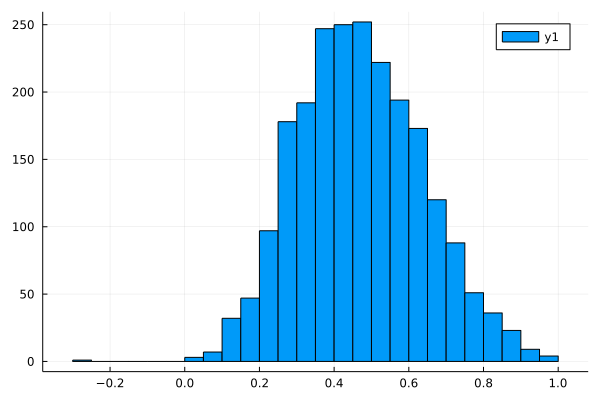

In [13]:
# ∑ⱼ γₙʲᵏ
gamma_sectdest = combine(groupby(cross_sector_spending, [:country, :sector_dest]), :gamma_n_jk => sum)

# γₙᵏ = 1 - ∑ⱼ γₙʲᵏ
gamma_sectdest[!, :gamma_n_k] = 1 .- gamma_sectdest[!,:gamma_n_jk_sum];

# Average value added 
avg_value_added_share = combine(groupby(gamma_sectdest, :sector_dest), :gamma_n_k => mean);

histogram(gamma_sectdest[!,:gamma_n_k])


Value added in initial equilibrium 

In [14]:
va⁰ = leftjoin(Xₙᵢʲ, gamma_sectdest, on=[:country_dest => :country, :sector_org => :sector_dest])
transform!(va⁰, [:gamma_n_k, :X_ni_j0] => (.*) => :value_added);
va⁰ = combine(groupby(va⁰, :country_dest), :value_added => sum, renamecols=false);


International transfers

In [15]:
# ∑ₒₖ Xₒₙᵏ
d1 = combine(groupby(df, :country_org), :trade_flow2014 => sum)
rename!(d1, :trade_flow2014_sum => :sum_x_on_k)

# ∑ₒₖ Xₙₒᵏ
d2 = combine(groupby(df, :country_dest), :trade_flow2014 => sum)
rename!(d2, :trade_flow2014_sum => :sum_x_no_k)

# h(w) Dₙ = ∑ₒₖ Xₙₒᵏ - ∑ₒₖ Xₒₙᵏ
transfers = innerjoin(d1, d2, on= :country_org => :country_dest)
transform!(transfers, [:sum_x_no_k, :sum_x_on_k] => (.-) => :transfer)

# Transfer as share of value added 
transfer_shares = innerjoin(transfers, va⁰, on= :country_org => :country_dest);



Final spending shares

In [16]:
# Rₙ⁰ = 0 since no tariff at baseline 

# ∑ᵢ Xₙᵢʲ is just total spending at destination across different origin sectors = total_spending_sectororg[!, :spending_sectororg]

# ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ: I think you should start with df
num = innerjoin(cross_sector_spending, Xₙᵢʲ, on=[:country => :country_org, :sector_dest => :sector_org])
transform!(num, [:X_ni_j0, :gamma_n_jk] => (.*) => :numerator)
num = combine(groupby(num, [:country, :sector_org]), :numerator => sum, renamecols = false)
select!(num, [:country, :sector_org, :numerator])

# αₙʲ = (∑ᵢ Xₙᵢʲ - ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ) / (Rₙ⁰ + wₙLₙ + h(w) Dₙ) 
num = innerjoin(num, transfer_shares, on=:country => :country_org)
num = innerjoin(num, total_spending_sectororg, on=[:country => :country_dest, :sector_org => :sector_org])
num.alpha_n_j = (num.spending_sectororg .- num.numerator) ./ (num.value_added .+ num.transfer);
#num.denom = num.value_added .+ num.sum_x_no_k .+ num.transfer;

# ᾱʲ 
avg_alpha = combine(groupby(num, [:sector_org]), :alpha_n_j => mean)
CSV.write("output/avg_alpha_j.csv", avg_alpha)

"output/avg_alpha_j.csv"

Calibrate $\theta^j$

In [17]:
theta_j = DataFrame(CSV.File("data/bilateral_trade_country/theta_caliendo_parro.csv"))
replace!(theta_j.theta_j, missing => mean(skipmissing(theta_j.theta_j))); # replace missing with average
θʲ = Array(theta_j[:,2]);


# Counterfactual Exercises

## Preview lets define things first

In [18]:
# Givens
gamma_i_kj = select(filter([:sector_dest, :sector_org] => (x, y) -> x <= size(θʲ, 1) && y <= size(θʲ, 1), cross_sector_spending), [:country, :sector_org, :sector_dest, :gamma_n_jk])
γᵢᵏʲ = zeros(42, size(θʲ, 1), size(θʲ, 1)) #country, sector_org, sector_dest
pi_ni_j = select(filter(:sector_org => x -> x <= size(θʲ, 1), Xₙᵢʲ), [:country_org, :country_dest, :sector_org, :pi_ni_j])
πₙᵢʲ = zeros(42, 42, size(θʲ, 1)) #country_org, country_dest, sector_org

for k in 1:size(θʲ, 1)
    γᵢᵏʲ[:, :, k] = Array(unstack(filter(:sector_dest => x -> x == k, gamma_i_kj), :country, :sector_org, :gamma_n_jk))[:, 2:end]
    πₙᵢʲ[:, :, k] = Array(unstack(filter(:sector_org => x -> x == k, pi_ni_j), :country_org, :country_dest, :pi_ni_j))[:, 2:end]
end

# country, sector_dest
γᵢʲ = Array(unstack(select(filter(:sector_dest => x -> x <= size(θʲ, 1), gamma_sectdest), [:country, :sector_dest, :gamma_n_jk_sum]), :country, :sector_dest, :gamma_n_jk_sum)[:, 2:end]);

λ̂ᵢʲ = ones(42, size(θʲ, 1))
#λ̂ᵢʲ[8, :] .= 1.1;

τ̂ = ones(42, 42)

αₙʲ = Array(unstack(num, :country, :sector_org, :alpha_n_j)[:,2:end]);

tfs = Array(transfers[!,:transfer]);



In [19]:
# to update
ŵ = ones(42, 1)
P̂ₙʲ = ones(42, size(θʲ, 1))


# First recover price index for all countries 
P_tilde_n_j = function (πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ)
    p_tilde_output = zeros(42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            inner = 0
            for country_org in 1:42 
                P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= (Pₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]) #i am flipping this because previously it was gamma_n^jk but now its gamma_i^kj
                end
                inner += πₙᵢ[country_org, country_dest, sector_org] * λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org])
            end
            p_tilde_output[country_dest, sector_org] = inner^(-1/θʲ[sector_org])
        end
    end
    
    return p_tilde_output
end


### here i think i am confused as to what is k and what is j??

# Iterate to find price index
iterate_p_tilde = function(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ, κ, tol)
    iter = 0
    P̂ = Pₙʲ 
    diff = Inf
    while maximum(diff) > tol
        iter +=1
        P̂_old = P̂
        P̂ = P_tilde_n_j(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂)
        diff = P̂ .- P̂_old
        P̂ = P̂ .+ κ .* diff
    end 
    
    return [P̂, iter]
end

p_b = iterate_p_tilde(πₙᵢʲ, λ̂ᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, 1, 1e-5);


In [20]:
# Given w and P find π̂
h(w) = w[end]
D̂ₙ = ones(42,1)

find_π_F = function(P̂ₙʲ, πₙᵢ, α, λᵢʲ, τ̂, ŵ, w⁰, γᵢʲ, tfs, D̂ₙ)
    π̂ₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
        for country_org in 1:42 
            P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= P̂ₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]
                end
                π̂ₙᵢʲ[country_org, country_dest, sector_org] = λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org]) * P̂ₙʲ[country_dest, sector_org]^(-θʲ[sector_org])
            end
        end
    end
    
    # work in progress
    Fₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            for country_org in 1:42 
                Fₙᵢʲ[country_org, country_dest, sector_org] = π̂ₙᵢʲ[country_org, country_dest, sector_org] * πₙᵢ[country_org, country_dest, sector_org] * α[country_dest, sector_org] * (w⁰[country_dest] * ŵ[country_dest] + tfs[country_dest] + h(w⁰[country_dest] * ŵ[country_dest]) / h(w⁰[country_dest]) * D̂ₙ[country_dest] )
            end
        end
    end
    
    return [π̂ₙᵢʲ, Fₙᵢʲ]
end



#17 (generic function with 1 method)

In [21]:
a = find_π_F(p_b[1], πₙᵢʲ, αₙʲ, λ̂ᵢʲ, τ̂, ŵ, Array(va⁰[!,:value_added]), γᵢʲ, tfs, D̂ₙ);

Time to invert something?

In [22]:
τ¹ = zeros(42, 42, size(θʲ, 1));

In [46]:
# 1st step compute some A matrix

# dimension NNJ is 42 * 42 * sectors
dimnnj = 42 * 42 * size(θʲ,1)

# create an index so that i can access different nnj's
index=[]
iter = 0
for country_dest in 1:42
    for country_org in 1:42
        for sector_org in 1:size(θʲ, 1)
            iter +=1 
            index = [index; (country_dest, country_org, sector_org)]
        end
    end
end

rowvec = hcat(index, zeros(dimnnj))
colvec = hcat(index, zeros(dimnnj))
valvec = []

### maybe i can just push this instead of allocating a massive index. this works but it takes a bit

for i in 1:size(rowvec, 1)
    println(i)
    for j in 1:size(colvec, 1)
        # if d==n
        obj1 = 0
        if rowvec[i][1] == colvec[j][1]
            #obj1 = αₙʲ[rowvec[i][1], rowvec[i][3]] * τ¹[colvec[i][1], colvec[i][2], colvec[i][3]] / (1 + τ¹[colvec[i][1], colvec[i][2], colvec[i][3]])
            obj1=1
        end
        
        # if o==n
        obj2 = 0 
        if rowvec[i][1] == colvec[j][2]
            #obj2 = γᵢᵏʲ[rowvec[i][1], rowvec[i][3], colvec[j][3]] / (1 + τ¹[colvec[j][1], colvec[j][2], colvec[j][3]])
            obj2=1
        end
        
        if obj1 + obj2 != 0 
            valvec = [valvec; (i,j)] #[valvec; [(i,j), obj1 + obj2]]
        end
    end
end


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220


LoadError: InterruptException:

In [47]:
A = zeros(dimnnj, dimnnj)

for x in 1

38808×38808 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [48]:
index

38808-element Vector{Any}:
 (1, 1, 1)
 (1, 1, 2)
 (1, 1, 3)
 (1, 1, 4)
 (1, 1, 5)
 (1, 1, 6)
 (1, 1, 7)
 (1, 1, 8)
 (1, 1, 9)
 (1, 1, 10)
 (1, 1, 11)
 (1, 1, 12)
 (1, 1, 13)
 ⋮
 (42, 42, 11)
 (42, 42, 12)
 (42, 42, 13)
 (42, 42, 14)
 (42, 42, 15)
 (42, 42, 16)
 (42, 42, 17)
 (42, 42, 18)
 (42, 42, 19)
 (42, 42, 20)
 (42, 42, 21)
 (42, 42, 22)

In [28]:
dimnnj = 42^2 * size(θʲ, 1)
A = spzeros(dimnnj,dimnnj)

38808×38808 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [ ]:
println( now() )
for i in 1:dimnnj
    #println(i)
    for j in 1:dimnnj
        # if d==n
        obj1 = 0
        if index[i][1] == index[j][1]
            #obj1 = αₙʲ[rowvec[i][1], rowvec[i][3]] * τ¹[colvec[i][1], colvec[i][2], colvec[i][3]] / (1 + τ¹[colvec[i][1], colvec[i][2], colvec[i][3]])
            obj1=1
        end
        
        # if o==n
        obj2 = 0 
        if index[i][1] == index[j][2]
            #obj2 = γᵢᵏʲ[rowvec[i][1], rowvec[i][3], colvec[j][3]] / (1 + τ¹[colvec[j][1], colvec[j][2], colvec[j][3]])
            obj2=1
        end
        
        if obj1 + obj2 != 0 
            A[i,j] = obj1 + obj2
        end
    end
end
println( now() )

In [24]:
index=[]
for country_dest in 1:42
    for country_org in 1:42
        for sector_org in 1:size(θʲ, 1)
            index = [index; (country_dest, country_org, sector_org)]
        end
    end
end

In [27]:
dimnnj

95256

In [35]:
println( now() )

2022-10-26T19:28:55.565


In [32]:
using Dates